In [2]:
import sys
import os
sys.path.append("..")

%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

%load_ext autoreload
%autoreload 2
from commembed.jupyter import *
from commembed.plots.social_dimensions import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
embedding = load_embedding('reddit', 'master')

# Words for figure 1 d and extended data

In [6]:
from commembed.data.urls import get_urls
from pyspark.sql.functions import *
from pyspark.sql.types import *
spark = data.spark_context()

columns = [
        col("author").cast(StringType()),
        col("subreddit").cast(StringType()),
        regexp_replace(regexp_replace(regexp_replace(regexp_replace(col("body"), "&gt;", ">"), "&lt;", "<"), "&amp;", "&"),"\\r\\n","\n").cast(StringType()).alias("body"),
        col("created_utc").cast(IntegerType()),
    ]

schema = "author STRING, subreddit STRING, body STRING, created_utc INTEGER"

filenames = list(get_urls("comments", only_study_period=False))
filenames = [f for f in filenames if "2017" in f[0]]

print("Creating DF")
df = spark.read.format("json").option("encoding", "UTF-8").schema(schema) \
    .load([("/ada/data/reddit/%s/%s" % ("comments", filename[0])) for filename in filenames])


print("Select")
df = df.select(*columns)

Spark WebUI: http://ada.ais.sandbox:4053
Creating DF
Select


In [ ]:
# To filter bots, we limit the amount of usages a word in a subreddit by one author are counted (to 100)
df = df.filter(df["body"] != "[deleted]")
df.createOrReplaceTempView("df")

spark.sql("""

    select author, subreddit, regexp_replace(lower(word), '[^a-z]', '') as word, least(100, count(*)) as count
    
    from (
        select author, subreddit, explode(split(body, ' +')) as word from df
    ) uncleaned_words
    
    where word not like 'http%' and word not like 'r/%'
    
    group by 1, 2, 3
    having word != ""
    
""").createOrReplaceTempView("words_by_author_and_sub")
spark.sql("""
    select subreddit, word, sum(count) as count
    from words_by_author_and_sub
    group by 1, 2
    --having count > 1000
""").write.parquet(data.DATA_PATH+"/word_totals_by_subreddit_2017_full.parquet")

In [ ]:
df = spark.read.load(data.DATA_PATH+"/word_totals_by_subreddit_2017_full.parquet")

only_political = True
dimen_list = dimens.load_dimen_list('final')
scores = dimens.score_embedding(embedding, dimen_list)
if only_political == True:
    scores, scores_df = load_politics_z_df("partisan", "all")
    
spark.createDataFrame(scores.reset_index()).createOrReplaceTempView("scores")
df.createOrReplaceTempView("subreddit_word_counts")

from pyspark.sql.types import FloatType
def udf_entropy(s):
    total = np.sum(s)
    
    return float(- np.sum((s/total) * np.log2((s/total))))

spark.udf.register("udf_entropy", udf_entropy, FloatType())

word_avgs = spark.sql(f"""

    select word, total_count, proportion_in_top_sub,
        {",".join(scores.columns)}, num_subreddits,
        udf_entropy(entropy_list) as entropy
        
    from (
        select word, sum(count) as total_count,
            max(count)/sum(count) as proportion_in_top_sub,
            {",".join(["sum(%s*count)/sum(count) as %s" % (d, d) for d in scores.columns])},
            collect_list(count) as entropy_list,
            count(*) as num_subreddits
        from subreddit_word_counts
        inner join scores
        on scores.community = subreddit_word_counts.subreddit
        group by 1
        having total_count > 10000
    ) words

""").cache()

word_avgs.createOrReplaceTempView("word_avgs")
spark.sql("""

    select word, partisan, total_count, num_subreddits, proportion_in_top_sub, entropy
    
    from (select * from word_avgs)

    where entropy > 5

    order by partisan asc
    
""").show(100)

fname = "top_words_political_only" if only_political else "top_words_for_plotting"

spark.sql("select * from word_avgs where entropy > 5") \
    .write.mode('overwrite').parquet("/ada/data/reddit/parquet/%s.parquet" % fname)

# Generating UMAP

Some inspiration from https://github.com/kylemcdonald/Coloring-t-SNE

CPU times: user 24 s, sys: 21.5 s, total: 45.5 s
Wall time: 732 ms
CPU times: user 2h 24s, sys: 16.7 s, total: 2h 41s
Wall time: 48.5 s


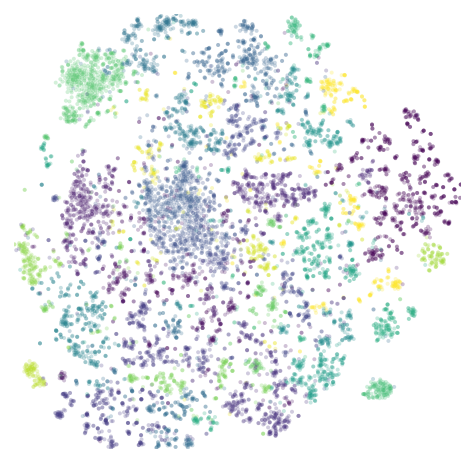

In [20]:
from sklearn.decomposition import IncrementalPCA

pca = IncrementalPCA(n_components=3)
%time pca_projection = pca.fit_transform(embedding.vectors)
pca_projection -= np.min(pca_projection, axis=0)
pca_projection /= np.max(pca_projection, axis=0)

do_umap = False

if do_umap:
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42, n_epochs=150)
    %time umap_vecs = reducer.fit_transform(embedding.vectors)
else:
    from sklearn.manifold import TSNE
    x = np.asarray(embedding.vectors, dtype='float64')
    %time umap_vecs = TSNE(n_components=2, init='pca', learning_rate=800).fit_transform(x)

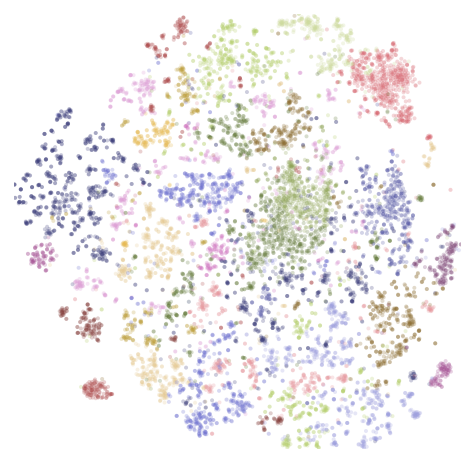

In [24]:
clustering = load_clustering('reddit_all_numbered')
to_plot = pd.DataFrame(umap_vecs, columns=['x', 'y'], index=embedding.vectors.index).join(clustering)
to_plot[["r", "g", "b"]] = pca_projection

to_plot[["r","g","b"]] = to_plot[["r","g","b"]].apply(lambda x: x - np.amin(x))
to_plot[["r","g","b"]] = to_plot[["r","g","b"]].apply(lambda x: x / np.amax(x))

fig = plt.figure(figsize=(4,4))
s = 4
plt.margins(0)
plt.axis('off')
plt.scatter(-to_plot["x"], to_plot["y"],  c=to_plot["cluster_id"],#c=np.vstack([to_plot["r"],to_plot["g"],to_plot["b"]]).T, 
            alpha=0.25,
           #marker=',',
           s=s,
            cmap='tab20b',
           lw=0)

In [25]:
# Save reduced version
to_plot.to_csv("fig_1_clustering_projection.csv")